In [20]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

In [21]:
def SIFT_features(img1, img5, plot = False):
    # Feature matching with SIFT
    img1_gray = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    img5_gray = cv.cvtColor(img5, cv.COLOR_RGB2GRAY)

    # Identify key points of each image
    sift = cv.SIFT_create(nOctaveLayers = 3,contrastThreshold = 0.09, edgeThreshold = 25, sigma = 1) 

    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints5, descriptors5 = sift.detectAndCompute(img5_gray, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors5, k=2)  # Find k best matches
    # Apply ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append(m)

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        img1_features = cv.drawKeypoints(img1_gray, keypoints1, img1_gray)
        plt.imshow(img1_features)
        plt.title("Image 1 SIFT features")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        img5_features = cv.drawKeypoints(img5_gray, keypoints5, img5_gray)
        plt.imshow(img5_features)
        plt.title("Image 5 SIFT features")
        plt.axis('off')
        plt.tight_layout()

        plt.figure()
        matched_img = cv.drawMatches(img1_gray, keypoints1, img5_gray, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(matched_img)
        plt.title("Matched features between image 1 and 5")
        plt.axis('off')

    return good_matches, keypoints1, keypoints5

In [22]:
def get_inliers(src_full, dst_full, tform, thres):
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum(np.square(dst_check - dst_full), axis = 1))

    return np.where(errors < thres)[0]

In [23]:
def find_homography(good_matches, keypoints1, keypoints5):
    src_full = []
    dst_full = []
    for match in good_matches:
        src_full.append(np.array(keypoints1[match.queryIdx].pt))
        dst_full.append(np.array(keypoints5[match.trainIdx].pt))
    src_full = np.array(src_full)
    dst_full = np.array(dst_full)
    num_points = 4
    thres = 1
    d = 0.5 * len(good_matches)
    iters = 200
    best_homography = None
    best_inlier_count = 0
    best_inliers = None
    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace = False)
        src_points = []
        dst_points = []
        for match in chosen_matches:
            src_points.append(np.array(keypoints1[match.queryIdx].pt))
            dst_points.append(np.array(keypoints5[match.trainIdx].pt))
        src_points = np.array(src_points)
        dst_points = np.array(dst_points)
        tform = transform.estimate_transform('projective', src_points, dst_points)
        inliers = get_inliers(src_full, dst_full, tform, thres)
        if len(inliers) > best_inlier_count:
            best_inlier_count = len(inliers)
            best_homography = tform
            best_inliers = inliers
    return best_homography, best_inliers

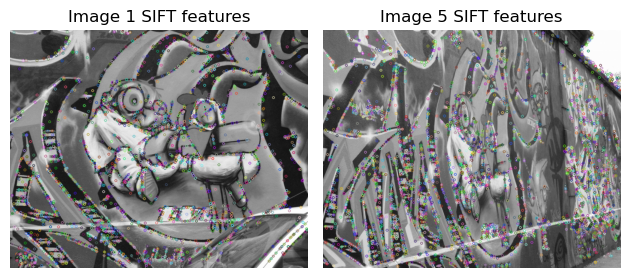

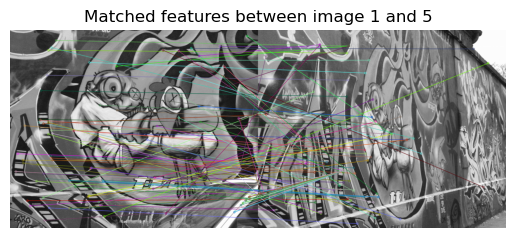

In [24]:
img1 = cv.imread("../../graf/img1.ppm")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img5 = cv.imread("../../graf/img5.ppm")
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

features = SIFT_features(img1, img5, plot = True)

Best no. of inliers = 677
Best no. of inliers = 628
Best no. of inliers = 610
Best no. of inliers = 505


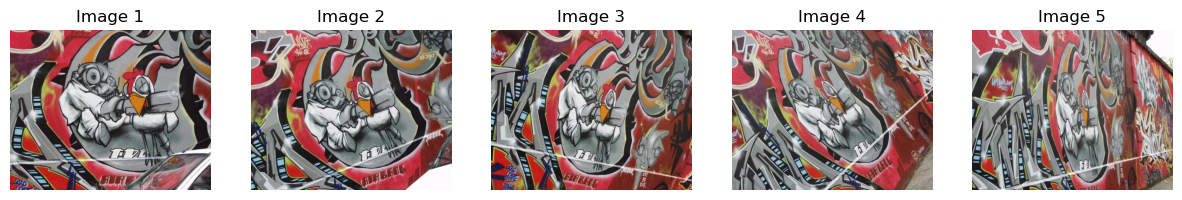

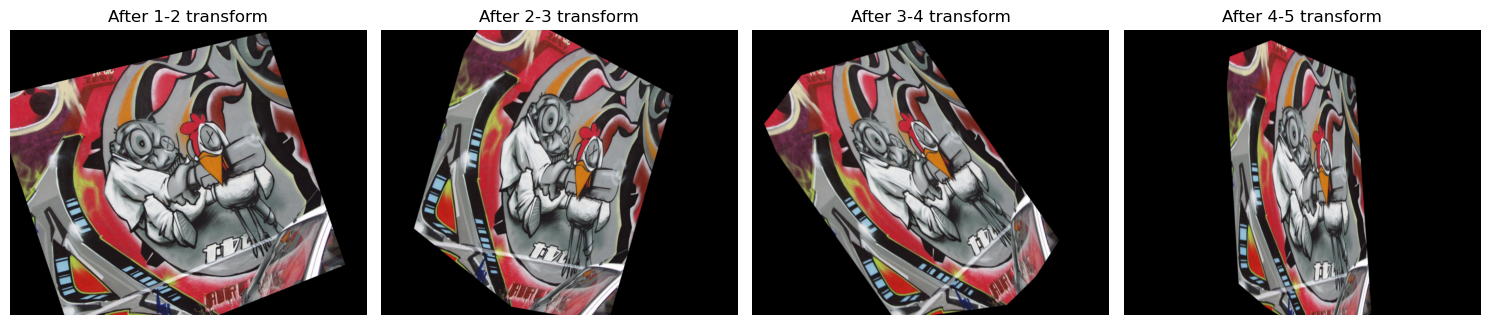

In [25]:
np.random.seed(82)
pad = 100

images = []
plt.figure(figsize = (15, 10))
for i in range(1, 6):
    img = cv.imread(f"../../graf/img{i}.ppm")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(f"Image {i}")
    plt.axis('off')

transformed_image = images[0].copy()
final_transform = transform.ProjectiveTransform(np.identity(3))

plt.figure(figsize = (15, 10))
for i in range(1, 5):
    img1, img2 = images[i-1], images[i]
    good_matches, keypoints1, keypoints5 = SIFT_features(img1, img2)
    tform, _ = find_homography(good_matches, keypoints1, keypoints5)
    transformed_image = transform.warp(transformed_image, tform.inverse)
    final_transform = final_transform + tform
    plt.subplot(1, 4, i)
    plt.imshow(transformed_image)
    plt.title(f"After {i}-{i+1} transform")
    plt.axis('off')
plt.tight_layout()
transformed_image = transform.warp(images[0], final_transform.inverse)

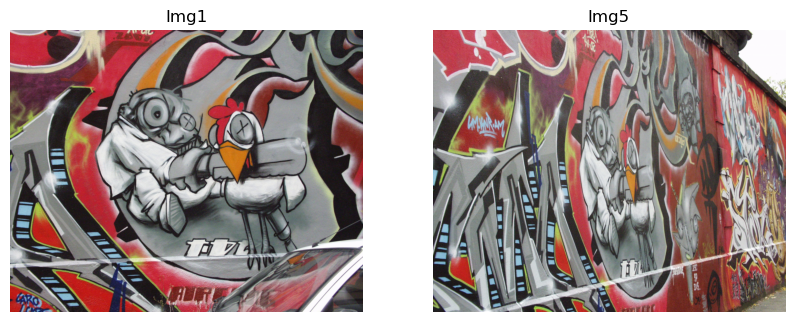

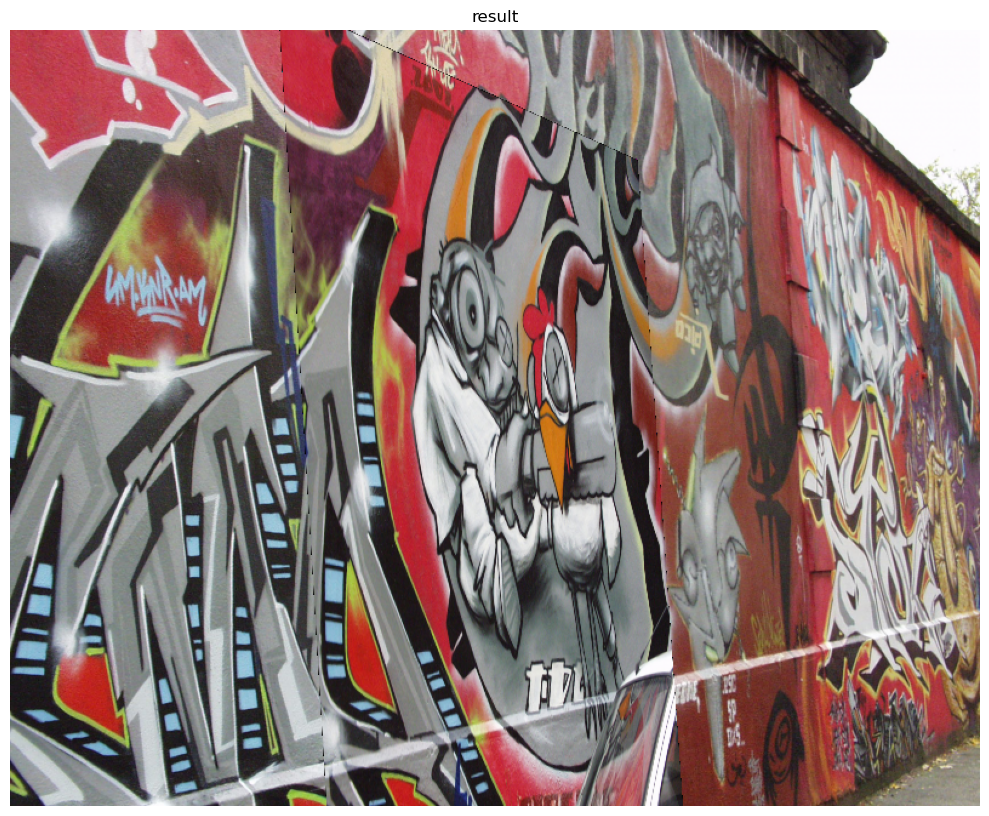

In [31]:
transformed_image = transform.warp(images[0], final_transform.inverse)
transformed_image = (transformed_image * 255).astype(np.uint8)
mask = (transformed_image == 0)
stitched_image = mask * images[4] + transformed_image

plt.figure(figsize = (10, 10))

plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.title("Img1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(images[4])
plt.title("Img5")
plt.axis('off')

plt.figure(figsize = (10, 10))
plt.imshow(stitched_image)
plt.title("result")
plt.axis('off')
plt.tight_layout()

In [30]:
actual_tform = np.array([[   6.2544644e-01,   5.7759174e-02,   2.2201217e+02],
 [  2.2240536e-01,   1.1652147e+00,  -2.5605611e+01],
 [  4.9212545e-04,  -3.6542424e-05,   1.0000000e+00]])

print("Homography Matrix")
print(final_transform.params)
print()
print("Given Homography Matrix")
print(actual_tform)
print()

print("Sum of squared errors:", np.sum(np.square(actual_tform - final_transform.params)))

Homography Matrix
[[ 6.18057912e-01  6.07853414e-02  2.19382479e+02]
 [ 2.16738670e-01  1.15694927e+00 -2.52514934e+01]
 [ 4.83851717e-04 -4.03656168e-05  9.93068043e-01]]

Given Homography Matrix
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]

Sum of squared errors: 7.040884988134116
